In [111]:
import numpy as np
import cv2 
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import pyrealsense2 as rs
import copy
import seaborn as sns
import scipy.stats as stats

%config InlineBackend.figure_format = 'retina'

In [2]:
def cv2pil(image):
    ''' OpenCV型 -> PIL型 '''
    new_image = image.copy()
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = new_image[:, :, ::-1]
    elif new_image.shape[2] == 4:  # 透過
        new_image = new_image[:, :, [2, 1, 0, 3]]
    new_image = Image.fromarray(new_image)
    return new_image

In [3]:
def detect_contour(image):

    #src = cv2.imread(path, cv2.IMREAD_COLOR)
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    retval, bw = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    detect_count = 0

    for i in range(0, len(contours)):
        area = cv2.contourArea(contours[i])
        
        if area < 1e4 or 1e5 < area:
            continue
            
        if len(contours[i]) > 0:
            rect = contours[i]
            x, y, w, h = cv2.boundingRect(rect)
          
    return y, y+h, x, x+w

In [4]:
config = rs.config()

config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

In [94]:
pipeline = rs.pipeline()
profile = pipeline.start(config)
align = rs.align(rs.stream.color)
count = 1
try:
    while True:

        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)
        
        color_frame = aligned_frames.get_color_frame()
        depth_frame = aligned_frames.get_depth_frame()
        if not depth_frame or not color_frame:
            continue
        
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        color_image = color_image[:, :, [2, 1, 0]]

        count += 1
        if count == 15:
            break                     

finally:
    # ストリーミング停止
    pipeline.stop()

In [95]:
check = cv2pil(color_image)
check.show()

In [96]:
unique_dict = {}
image_list = []
depth_copy = copy.deepcopy(depth_image)
for col in depth_image:
    for one in col:
        if one > 1000:
            image_list.append(0)
        else:
            image_list.append(one)
        if one not in unique_dict:
            unique_dict[one] = 1
        else:
            unique_dict[one] +=1
img_list_zoom = []
for pixel in image_list:
    if pixel > 150 and pixel < 338:
        img_list_zoom.append(pixel)
        
for y, col in enumerate(depth_image):
    for x, pixel in enumerate(col):
        if pixel > 150 and pixel < 338: 
            depth_image[y][x] = 255
        else:
            depth_image[y][x] = 0
image = np.array(depth_image, dtype=np.uint8)

In [97]:
y1, y2, x1, x2 = detect_contour(image)

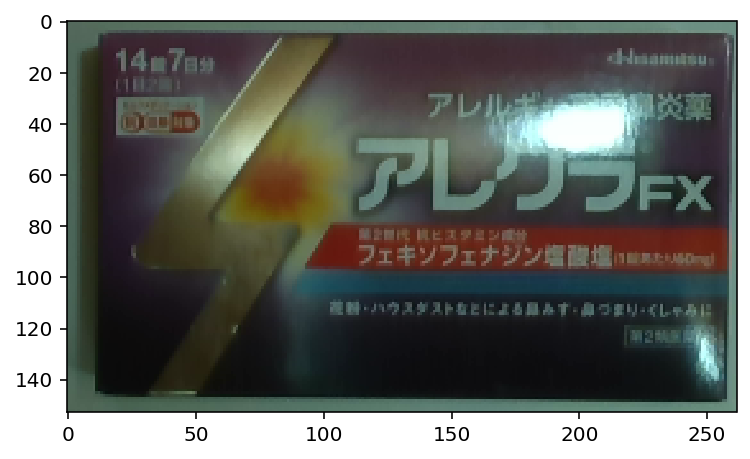

In [98]:
img = image[y1:y2, x1:x2]
color = color_image[y1:y2, x1:x2]
plt.imshow(color)

In [99]:
r = color.T[0].flatten()
g = color.T[1].flatten()
b = color.T[2].flatten()

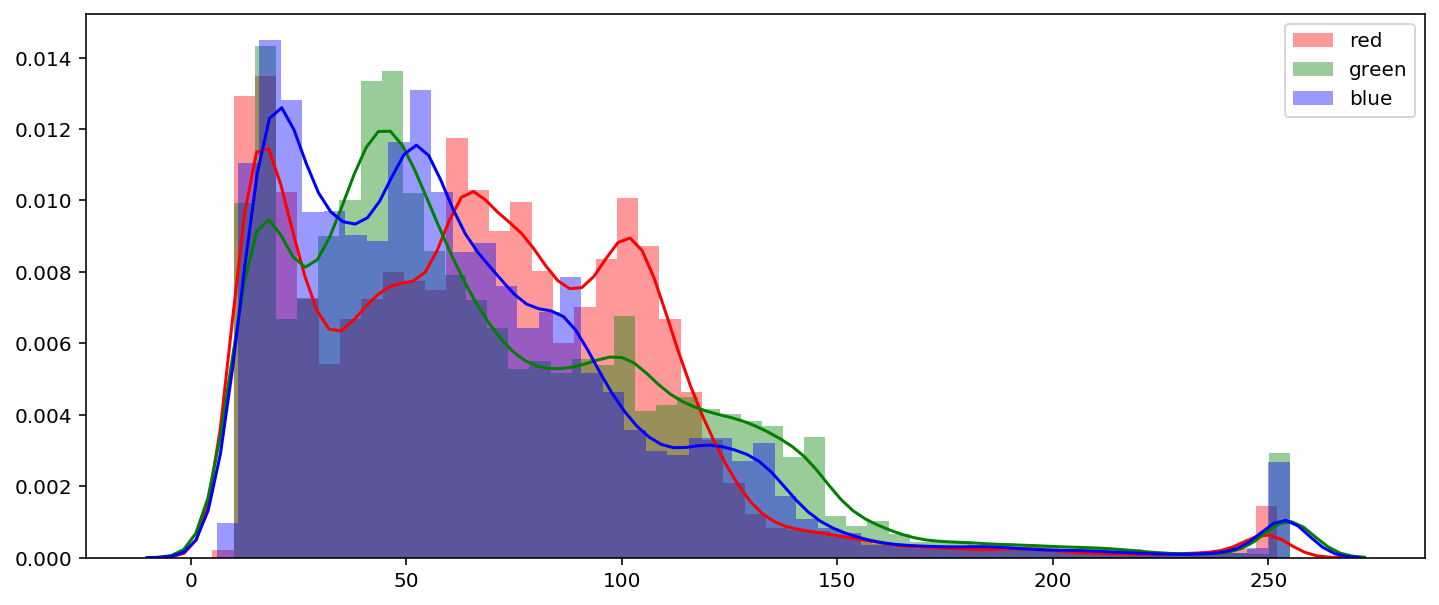

In [100]:
plt.figure(figsize=(12, 5))
sns.distplot(r, color='red', label='red')
sns.distplot(g, color='green', label='green')
sns.distplot(b, color='blue', label='blue')
plt.legend()

In [112]:
r_median = np.median(r)
b_median = np.median(b)
g_median = np.median(g)

r_mean = np.mean(r)
b_mean = np.mean(b)
g_mean = np.mean(g)

r_sum = np.sum(r)
b_sum = np.sum(b)
g_sum = np.sum(g)

In [102]:
detector = cv2.ORB_create()

# 特徴検出
keypoints = detector.detect(color)

In [103]:
len(keypoints)

330

In [83]:
keypoints[0].pt

(162.0, 118.0)